# Libraries

In [832]:
import numpy as np #array operations
import matplotlib.pyplot as plt #ploting operations
from matplotlib.image import imread #display images

# from torchvision.datasets import ImageFolder
# import torchvision.transforms as transforms

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers #model building

#from sklearn.model_selection import train_test_split #Split data
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


#Transfer learning 
from tensorflow.keras.applications import EfficientNetB0


In [833]:
# CONSTANTS
DATASET_DIR = 'PokemonData/' #Folder in current working directory 
IMG_SIZE = 64 #(Height, Width) Can rerun with bigger dims
BATCH_SIZE = 32 #Want Data Split to have same batch size
SEED = 1337 #Want Data Split to have same seed

# Image Loading
Dataset from kaggle contains 6820 (150 unique) pokemon images of varying size from google
This Dataset doesn't contain NidoranM or NidoranF from the original 151 pokemon and adds alolan Sandslash for some reason. I decided not to change that because the two are extremely similar.

In [834]:
#Assigns the (dataset) images class numbers in alphabetical order  
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATASET_DIR, 
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATASET_DIR, 
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 6820 files belonging to 150 classes.
Using 5456 files for training.
Found 6820 files belonging to 150 classes.
Using 1364 files for validation.


In [835]:
class_names = train_data.class_names #The list contains all class names in alphabetic order
print(class_names[:5]) #Display first 5
NUM_CLASSES = len(class_names) #150

['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok']


# Visualization of Images and Class

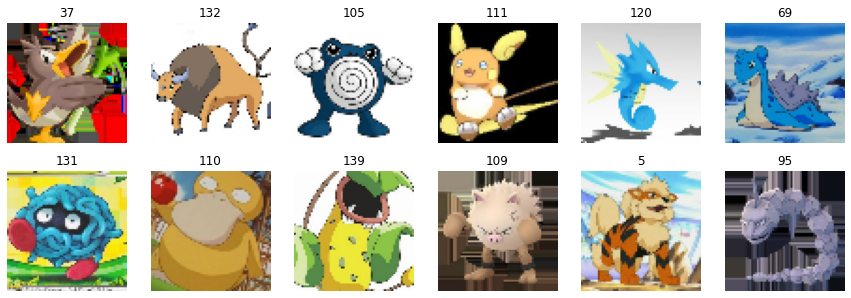

In [836]:
#Print 25 samples (following lab4b and https://www.tensorflow.org/tutorials/images/classification)
plt.figure(figsize=(15, 5))
for images, labels in train_data.take(1):
    for i in range(12):
        ax = plt.subplot(2, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Data Augmentation
The dataset already contains a lot of Data and I can easily fetch more images from other compiled sets or google, but I'll try to use simple Flip, Rotation and Zoom operations to augment data as seen in lab4b and https://www.tensorflow.org/tutorials/images/classification

In [837]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip(),
        layers.experimental.preprocessing.RandomRotation(0.15),
        layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
        layers.experimental.preprocessing.RandomContrast(factor=0.1),
    ]
)

In [838]:
#Less seemed to yeild higher validation accuracy, will use for my basic model
data_augmentation2 = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip(),
        layers.experimental.preprocessing.RandomRotation(0.15),
        layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

# Data Preprocessing
Standardizing RBG values to [0,1] by using a Rescaling layer
Data_augmentation preprocessor will execute synchronously with the rest of the model execution to benefit from GPU acceleration

In [840]:
#Configure the dataset for performance
train_data = train_data.prefetch(buffer_size=32)
val_data = val_data.prefetch(buffer_size=32)

In [841]:
#Basic model from Tensorflow tutorial with some changes
#Tried making model more complex (adding more filters, dense layers, another drop out layer at the end but it did not seem to improve the model fit)
model = keras.Sequential([
    data_augmentation2, #Preprocess
    layers.Rescaling(1./255), #Preprocess
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2), #Combats overfitting
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES)
])

# Train (compile and fit) model

In [842]:
epochs = 100 #tried several different epoachs, and img resolutions
#Got 60 val accuracy before adding more data augmentation layers during on of my runs, 
#I guess it leads to more overfitting for some reason

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(
    train_data, epochs=epochs, callbacks=callbacks, validation_data=val_data
)

Epoch 1/100
171/171 [==============================] - 23s 125ms/step - loss: 4.8017 - accuracy: 0.0192 - val_loss: 4.3568 - val_accuracy: 0.0440
Epoch 2/100
171/171 [==============================] - 21s 121ms/step - loss: 3.9833 - accuracy: 0.0737 - val_loss: 3.7241 - val_accuracy: 0.1026
Epoch 3/100
171/171 [==============================] - 21s 120ms/step - loss: 3.5094 - accuracy: 0.1285 - val_loss: 3.3317 - val_accuracy: 0.1591
Epoch 4/100
171/171 [==============================] - 20s 114ms/step - loss: 3.2021 - accuracy: 0.1815 - val_loss: 3.1483 - val_accuracy: 0.2075
Epoch 5/100
171/171 [==============================] - 25s 148ms/step - loss: 2.9488 - accuracy: 0.2269 - val_loss: 2.9123 - val_accuracy: 0.2500
Epoch 6/100
171/171 [==============================] - 26s 149ms/step - loss: 2.7513 - accuracy: 0.2678 - val_loss: 2.7943 - val_accuracy: 0.2757
Epoch 7/100
171/171 [==============================] - 24s 135ms/step - loss: 2.6031 - accuracy: 0.3010 - val_loss: 2.6864 -

Epoch 57/100
171/171 [==============================] - 19s 112ms/step - loss: 0.8941 - accuracy: 0.7165 - val_loss: 2.2942 - val_accuracy: 0.5411
Epoch 58/100
171/171 [==============================] - 23s 133ms/step - loss: 0.8523 - accuracy: 0.7326 - val_loss: 2.4346 - val_accuracy: 0.5352
Epoch 59/100
171/171 [==============================] - 22s 128ms/step - loss: 0.8268 - accuracy: 0.7425 - val_loss: 2.3614 - val_accuracy: 0.5367
Epoch 60/100
171/171 [==============================] - 22s 127ms/step - loss: 0.8348 - accuracy: 0.7399 - val_loss: 2.2724 - val_accuracy: 0.5330
Epoch 61/100
171/171 [==============================] - 21s 120ms/step - loss: 0.8206 - accuracy: 0.7460 - val_loss: 2.4002 - val_accuracy: 0.5359
Epoch 62/100
171/171 [==============================] - 19s 110ms/step - loss: 0.8388 - accuracy: 0.7346 - val_loss: 2.5057 - val_accuracy: 0.5315
Epoch 63/100
171/171 [==============================] - 20s 116ms/step - loss: 0.8395 - accuracy: 0.7350 - val_loss: 2

# Visualize Training Results

In [843]:
# Method to print test-val accuracy and test-val loss
def plot_acc_loss(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.ylabel("accuracy")
    plt.xlabel("epoch")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.show()

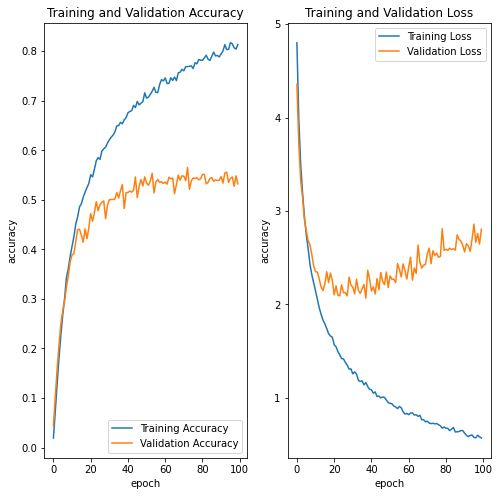

In [844]:
plot_acc_loss(history)

This image most likely belongs to Alakazam with a 39.84 percent confidence.


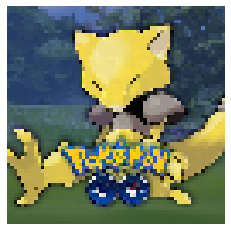

In [845]:
ABRA = 'abra.jpg' #Unseen Abra I downloaded from google

img = tf.keras.utils.load_img(
    ABRA, target_size=(IMG_SIZE, IMG_SIZE)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

plt.imshow(img)
plt.axis("off")

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Created a Testing DataSet to test measures of accuracy because I didn't want to split my current Training Set. Testing Set contains at least 5 images per class sourced from google using one month filter to get different images from Training/Validation Data

In [848]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='TestData/', 
    seed=SEED,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 795 files belonging to 150 classes.


In [849]:
#y_pred = model.predict(test_data)
model.evaluate(test_data)

25/25 [==============================] - 3s 81ms/step - loss: 9.1340 - accuracy: 0.2327


[9.134005546569824, 0.23270440101623535]

# Visualization of Accuracies

In [859]:
#Method to print sklearn metrics for classification data
def print_metrics(targets, predictions):
    accuracy = accuracy_score(targets, predictions) * 100
    f1 = f1_score(targets, predictions, average='macro', zero_division=1)
    recall = recall_score(targets, predictions, average='macro', zero_division=1)
    precision = precision_score(targets, predictions, average='macro', zero_division=1)
    print('Accuracy: %.3f \nF-score: %.3f \nRecall: %.3f \nPrecision: %.3f' % (accuracy, f1, recall, precision))

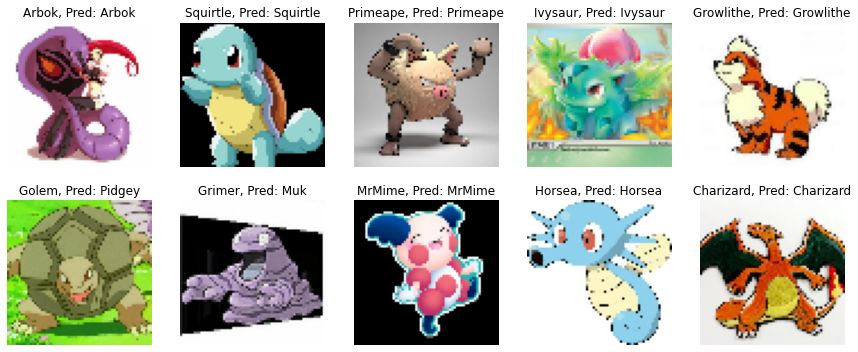

In [855]:
#Validation Accuracy for the basic CNN was 53 percent
plt.figure(figsize=(15, 6))
y_test = np.array([])
y_pred = []
for images, labels in val_data.take(1):
    for i in range(BATCH_SIZE): #32
        
        predictions = model.predict(images)
        score = tf.nn.softmax(predictions[i])
        
        if i < 10: #only want to print first 10 but want to get true labels and prediction labels for batch
            ax = plt.subplot(2, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))

            plt.title(str(class_names[labels[i]]) + ', Pred: ' + str(class_names[np.argmax(score)]))
            plt.axis("off")
       
        true = class_names[labels[i]] #actual labels casted to their class name
        y_test = np.append(y_test, true)
        pred = class_names[np.argmax(score)] # predicted labels casted into their class names
        y_pred = np.append(y_pred, pred)

In [856]:
print_metrics(y_test, y_pred)

Accuracy: 68.750 
F-score: 0.537 
Recall: 0.764 
Precision: 0.750


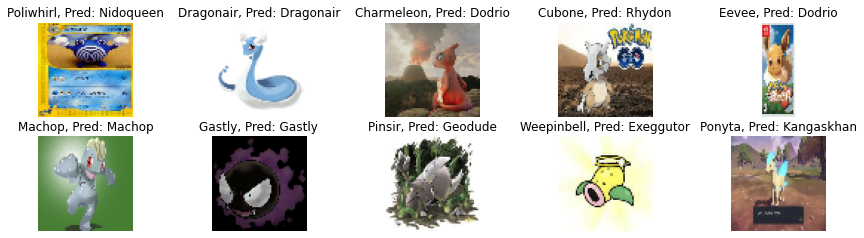

In [857]:
#Test Accuracy for the basic CNN was 23 percent
plt.figure(figsize=(15, 8))
y_test = np.array([])
y_pred = []
for images, labels in test_data.take(1):
    for i in range(BATCH_SIZE): 
        
        predictions = model.predict(images)
        score = tf.nn.softmax(predictions[i])
        
        if i < 10: #only want to print first 10 but want to get true labels and prediction labels for batch
            ax = plt.subplot(4, 5, i + 1) #prints 20 if i <20
            plt.imshow(images[i].numpy().astype("uint8"))

            plt.title(str(class_names[labels[i]]) + ', Pred: ' + str(class_names[np.argmax(score)]))
            plt.axis("off")
       
        true = class_names[labels[i]] #actual labels casted to their class name
        y_test = np.append(y_test, true)
        pred = class_names[np.argmax(score)] # predicted labels casted into their class names
        y_pred = np.append(y_pred, pred)

In [858]:
#Classification (we have 150 classes but only using 32 samples here)
#print(classification_report(y_test, y_pred, zero_division=1))

print_metrics(y_test, y_pred)

Accuracy: 31.250 
F-score: 0.199 
Recall: 0.543 
Precision: 0.576


# EfficientNet Model
Model from lab10

In [649]:
IMG_SIZE = 224 #size determined by EfficientNet model choice
SIZE = (IMG_SIZE, IMG_SIZE)
BATCH_SIZE = 64

In [650]:
#Reloading Dataset in higher resolution 
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATASET_DIR, 
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATASET_DIR, 
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

train_data = train_data.map(lambda image, label: (tf.image.resize(image, SIZE), label))
val_data = val_data.map(lambda image, label: (tf.image.resize(image, SIZE), label))

Found 6820 files belonging to 150 classes.
Using 5456 files for training.
Found 6820 files belonging to 150 classes.
Using 1364 files for validation.


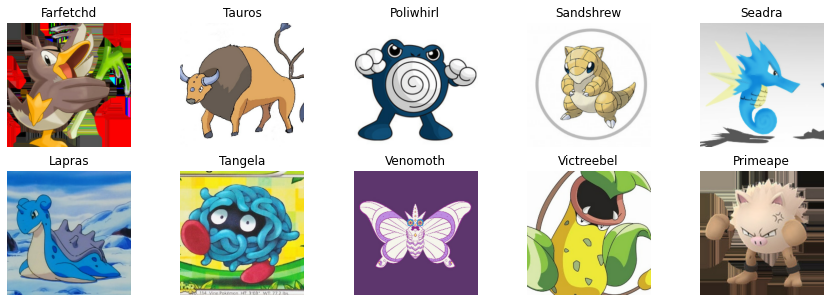

In [633]:
#Visualize images with higher resolution
plt.figure(figsize=(15, 5))
for images, labels in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str(class_names[labels[i]]))
        plt.axis("off")

# Data augmentation

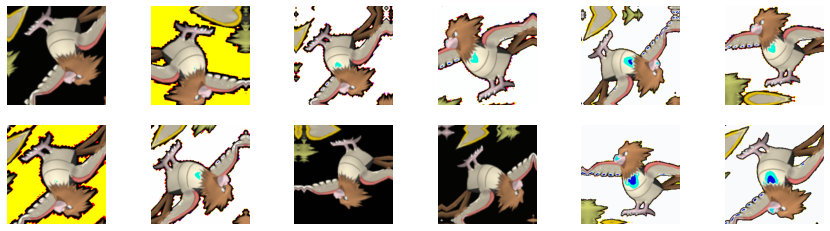

In [639]:
plt.figure(figsize=(15,4))
for images, labels in train_data.take(1):
    for i in range(12):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(2, 6, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# EfficientNet Model

In [660]:
def EfficientNet(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="SparseCategoricalCrossentropy", metrics=["accuracy"]
    )
    return model


In [661]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [667]:
epochs = 15 # @param {type: "slider", min:8, max:80}

with strategy.scope():
    model = EfficientNet(num_classes=NUM_CLASSES)
    
hist = model.fit(train_data, epochs=epochs, validation_data=val_data, verbose=2)

Epoch 1/15
86/86 - 274s - loss: 3.3620 - accuracy: 0.4080 - val_loss: 1.7921 - val_accuracy: 0.5601 - 274s/epoch - 3s/step
Epoch 2/15
86/86 - 275s - loss: 1.4827 - accuracy: 0.6760 - val_loss: 1.5045 - val_accuracy: 0.6378 - 275s/epoch - 3s/step
Epoch 3/15
86/86 - 254s - loss: 1.0946 - accuracy: 0.7434 - val_loss: 1.3813 - val_accuracy: 0.6987 - 254s/epoch - 3s/step
Epoch 4/15
86/86 - 257s - loss: 0.8494 - accuracy: 0.7927 - val_loss: 1.5965 - val_accuracy: 0.6774 - 257s/epoch - 3s/step
Epoch 5/15
86/86 - 256s - loss: 0.7698 - accuracy: 0.8032 - val_loss: 1.5727 - val_accuracy: 0.6928 - 256s/epoch - 3s/step
Epoch 6/15
86/86 - 297s - loss: 0.7197 - accuracy: 0.8149 - val_loss: 1.4767 - val_accuracy: 0.7097 - 297s/epoch - 3s/step
Epoch 7/15
86/86 - 314s - loss: 0.6330 - accuracy: 0.8332 - val_loss: 1.6664 - val_accuracy: 0.7016 - 314s/epoch - 4s/step
Epoch 8/15
86/86 - 308s - loss: 0.6134 - accuracy: 0.8347 - val_loss: 1.6859 - val_accuracy: 0.7082 - 308s/epoch - 4s/step
Epoch 9/15
86/86

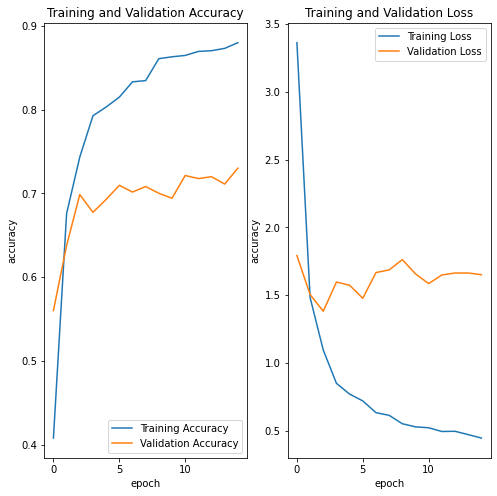

In [670]:
plot_acc_loss(hist)

In [671]:
def unfreeze_model(model):
    # unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="SparseCategoricalCrossentropy", metrics=["accuracy"]
    )

epochs = 10  # @param {type: "slider", min:8, max:50}
unfreeze_model(model)
hist = model.fit(train_data, epochs=epochs, validation_data=val_data, verbose=2)

Epoch 1/10
86/86 - 305s - loss: 0.3152 - accuracy: 0.9122 - val_loss: 1.3403 - val_accuracy: 0.7676 - 305s/epoch - 4s/step
Epoch 2/10
86/86 - 397s - loss: 0.2203 - accuracy: 0.9360 - val_loss: 1.3046 - val_accuracy: 0.7683 - 397s/epoch - 5s/step
Epoch 3/10
86/86 - 364s - loss: 0.1736 - accuracy: 0.9465 - val_loss: 1.2224 - val_accuracy: 0.7786 - 364s/epoch - 4s/step
Epoch 4/10
86/86 - 312s - loss: 0.1572 - accuracy: 0.9534 - val_loss: 1.2024 - val_accuracy: 0.7874 - 312s/epoch - 4s/step
Epoch 5/10
86/86 - 317s - loss: 0.1585 - accuracy: 0.9507 - val_loss: 1.1502 - val_accuracy: 0.7962 - 317s/epoch - 4s/step
Epoch 6/10
86/86 - 280s - loss: 0.1521 - accuracy: 0.9498 - val_loss: 1.1990 - val_accuracy: 0.7947 - 280s/epoch - 3s/step
Epoch 7/10
86/86 - 268s - loss: 0.1328 - accuracy: 0.9643 - val_loss: 1.1075 - val_accuracy: 0.7991 - 268s/epoch - 3s/step
Epoch 8/10
86/86 - 272s - loss: 0.1289 - accuracy: 0.9655 - val_loss: 1.1415 - val_accuracy: 0.8079 - 272s/epoch - 3s/step
Epoch 9/10
86/86

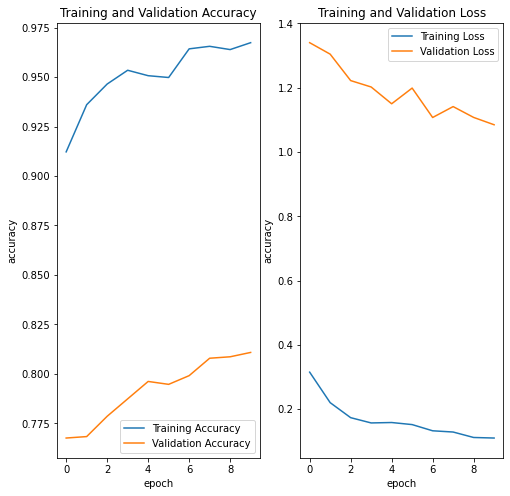

In [672]:
plot_acc_loss(hist)

# Visualization of Accuracies
validation and test

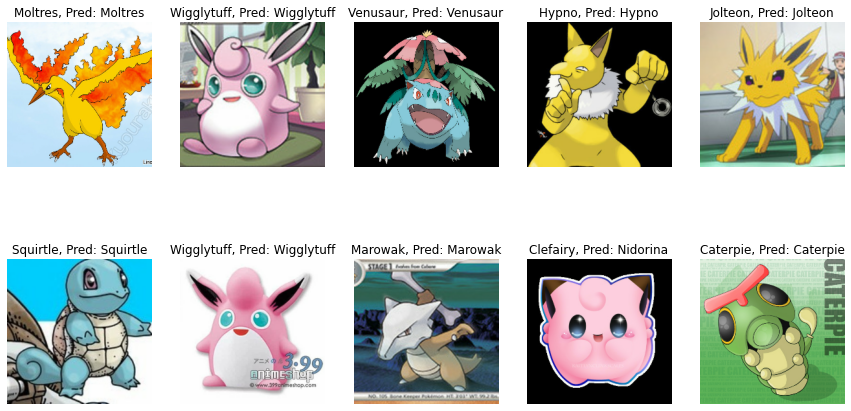

In [682]:
#Validation Accuracy for the EfficientNet was 81 percent
plt.figure(figsize=(15, 8))
y_test = np.array([])
y_pred = []
for images, labels in val_data.take(1):
    for i in range(BATCH_SIZE): #64 here
        
        predictions = model.predict(images)
        score = tf.nn.softmax(predictions[i])
        
        if i < 10: #only want to print first 10 but want to get true labels and prediction labels for batch
            ax = plt.subplot(2, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))

            plt.title(str(class_names[labels[i]]) + ', Pred: ' + str(class_names[np.argmax(score)]))
            plt.axis("off")
       
        true = class_names[labels[i]] #actual labels casted to their class name
        y_test = np.append(y_test, true)
        pred = class_names[np.argmax(score)] # predicted labels casted into their class names
        y_pred = np.append(y_pred, pred)

In [683]:
#On a batch of 64 samples
print_metrics(y_test, y_pred)

Accuracy: 87.500 
F-score: 0.794 
Recall: 0.892 
Precision: 0.886


In [676]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='TestData/', 
    seed=SEED,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 795 files belonging to 150 classes.


In [677]:
model.evaluate(test_data)
#Above 50 percent accuracy for images I downloaded isn't too bad considering some aren't great

13/13 [==============================] - 26s 2s/step - loss: 3.5603 - accuracy: 0.5358


[3.560338258743286, 0.5358490347862244]

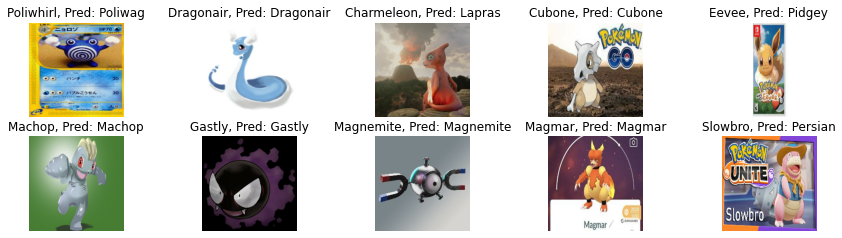

In [680]:
#Test Accuracy for the basic CNN was 24 percent
plt.figure(figsize=(15, 8))
y_test = np.array([])
y_pred = []
for images, labels in test_data.take(1):
    for i in range(BATCH_SIZE): #64 here
        
        predictions = model.predict(images)
        score = tf.nn.softmax(predictions[i])
        
        if i < 10: #only want to print first 10 but want to get true labels and prediction labels for batch
            ax = plt.subplot(4, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))

            plt.title(str(class_names[labels[i]]) + ', Pred: ' + str(class_names[np.argmax(score)]))
            plt.axis("off")
       
        true = class_names[labels[i]] #actual labels casted to their class name
        y_test = np.append(y_test, true)
        pred = class_names[np.argmax(score)] # predicted labels casted into their class names
        y_pred = np.append(y_pred, pred)

In [681]:
#On a batch of 64 samples
print_metrics(y_test, y_pred)

Accuracy: 62.500 
F-score: 0.469 
Recall: 0.662 
Precision: 0.772
